In [160]:
import os, json,time, re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import scipy.io as sio
import pandas as pd
from operator import truediv
from sklearn.manifold import TSNE
from sklearn.decomposition import IncrementalPCA,  PCA
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.utils import to_categorical
from keras.layers import (Conv3D, Dense, Dropout, LayerNormalization,
                          Flatten, Input, Reshape, concatenate, Reshape, ReLU)

In [ ]:
## Loading Hyperspectral Datasets
def LoadHSIData(method):
    data_path = os.path.join(os.getcwd(),'../HSI/')
    if method == 'HC':
        HSI = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan.mat'))['WHU_Hi_HanChuan']
        GT = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan_gt'))['WHU_Hi_HanChuan_gt']
        Num_Classes = 16
        target_names = ['Strawberry', 'Cowpea', 'Soybean', 'Sorghum',
                        'Water spinach', 'Watermelon', 'Greens', 'Trees', 'Grass',
                        'Red roof', 'Gray roof', 'Plastic', 'Bare soil', 'Road',
                        'Bright object', 'Water']
    elif method == 'PU':
        HSI = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        GT = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
        Num_Classes = 9
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted','Soil','Bitumen',
                        'Bricks','Shadows']
    return HSI, GT, Num_Classes, target_names

def DLMethod(method, HSI, NC = 75):
    RHSI = np.reshape(HSI, (-1, HSI.shape[2]))
    if method == 'PCA':
        pca = PCA(n_components = NC, whiten = True)
        RHSI = pca.fit_transform(RHSI)
        RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
    elif method == 'iPCA':
        n_batches = 256
        inc_pca = IncrementalPCA(n_components = NC)
        for X_batch in np.array_split(RHSI, n_batches):
          inc_pca.partial_fit(X_batch)
        X_ipca = inc_pca.transform(RHSI)
        RHSI = np.reshape(X_ipca, (HSI.shape[0], HSI.shape[1], NC))
    return RHSI

def TrTeSplit(HSI, GT, trRatio, vrRatio, teRatio, randomState=345):
    Tr, Te, TrC, TeC = train_test_split(HSI, GT, test_size=teRatio,
                                        random_state=randomState, stratify=GT)
    totalTrRatio = trRatio + vrRatio
    new_vrRatio = vrRatio / totalTrRatio
    Tr, Va, TrC, VaC = train_test_split(Tr, TrC, test_size=new_vrRatio,
                                        random_state=randomState, stratify=TrC)
    return Tr, Va, Te, TrC, VaC, TeC

HSID = "PU"
DLM = "PCA"
WS = 12
teRatio = 0.50
vrRatio = 0.50
trRatio = 0.50
k = 15
adam = tf.keras.optimizers.legacy.Adam(lr = 0.001, decay = 1e-06)
epochs = 50
batch_size = 56

def ImageCubes(HSI, GT, WS=WS, removeZeroLabels=True):
    num_rows, num_cols, num_bands = HSI.shape
    margin = int(WS / 2)
    padded_data = np.pad(HSI, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    image_cubes = np.zeros((num_rows * num_cols, WS, WS, num_bands))
    patchesLabels = np.zeros((num_rows * num_cols))
    patchIndex = 0
    for r in range(margin, num_rows + margin):
        for c in range(margin, num_cols + margin):
            cube = padded_data[r - margin: r + margin, c - margin: c + margin, :]
            image_cubes[patchIndex, :, :, :] = cube
            patchesLabels[patchIndex] = GT[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
      image_cubes = image_cubes[patchesLabels>0,:,:,:]
      patchesLabels = patchesLabels[patchesLabels>0]
      patchesLabels -= 1
    return image_cubes, patchesLabels

HSI, GT, Num_Classes, target_names = LoadHSIData(HSID)
start = time.time()
RDHSI = DLMethod(DLM, HSI, NC = k)
end = time.time()
DL_Time = end - start
CRDHSI, CGT = ImageCubes(RDHSI, GT, WS = WS)
Tr, Va, Te, TrC, VaC, TeC = TrTeSplit(CRDHSI, CGT, trRatio, vrRatio, teRatio)
TrC = to_categorical(TrC)
VaC = to_categorical(VaC)
TeC = to_categorical(TeC)
CHSI = to_categorical(CGT)

def ClassificationReports(TeC, Te_Pred, target_names):
    classification = classification_report(np.argmax(TeC, axis=1), np.argmax(Te_Pred, axis=1), target_names = target_names)
    oa = accuracy_score(np.argmax(TeC, axis=1), np.argmax(Te_Pred, axis=1))
    confusion = confusion_matrix(np.argmax(TeC, axis=1), np.argmax(Te_Pred, axis=1))
    list_diag = np.diag(confusion)
    list_raw_sum = np.sum(confusion, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    aa = np.mean(each_acc)
    kappa = cohen_kappa_score(np.argmax(TeC, axis=1), np.argmax(Te_Pred, axis=1))
    return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100

def CSVResults(file_name, classification, Confusion, Parameters,
                          Flops, Tr_time, Te_Time, Kappa, OA, AA, Per_Class):
    classification = str(classification)
    confusion = str(Confusion)
    with open(file_name, 'w') as CSV_file:
      CSV_file.write('{} Tr_Time'.format(Tr_time))
      CSV_file.write('\n')
      CSV_file.write('{} Te_Time'.format(Te_Time))
      CSV_file.write('\n')
      CSV_file.write('{} Flops'.format(Flops))
      CSV_file.write('\n')
      CSV_file.write('{} Parameters'.format(Parameters))
      CSV_file.write('\n')
      CSV_file.write('{} Kappa accuracy (%)'.format(Kappa))
      CSV_file.write('\n')
      CSV_file.write('{} Overall accuracy (%)'.format(OA))
      CSV_file.write('\n')
      CSV_file.write('{} Average accuracy (%)'.format(AA))
      CSV_file.write('\n')
      CSV_file.write('{}'.format(Per_Class))
      CSV_file.write('\n')
      CSV_file.write('{}'.format(classification))
      CSV_file.write('\n')
      CSV_file.write('{}'.format(Confusion))
    return CSV_file

def GT_Plot(CRDHSI, GT, model, WS, k):
  Predicted = model.predict(CRDHSI)
  Predicted = np.argmax(Predicted, axis=1)
  height, width = np.shape(GT)
  outputs = np.zeros((height, width))
  count = 0
  for AA in range(height):
    for BB in range(width):
      target = int(GT[AA,BB])
      if target == 0:
        continue
      else:
        outputs[AA][BB] = Predicted[count]
        count = count+1
  return outputs

def get_flops(model):
    total_flops = 0
    for layer in model.layers:
        flops = 0
        if isinstance(layer, tf.keras.layers.Conv2D):
            kernel_size = layer.kernel_size[0] * layer.kernel_size[1] * layer.input_shape[-1]
            flops = kernel_size * layer.output_shape[1] * layer.output_shape[2] * layer.filters
        elif isinstance(layer, tf.keras.layers.Dense):
            flops = layer.input_shape[-1] * layer.units
        elif isinstance(layer, tf.keras.layers.Flatten):
            continue
        total_flops += flops
    return total_flops

def compute_flops(model):
    flops = get_flops(model)
    return flops

Model: "DSST"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 12, 12, 15)]         0         []                            
                                                                                                  
 tf.expand_dims_12 (TFOpLam  (None, 1, 12, 12, 15)        0         ['inputs[0][0]']              
 bda)                                                                                             
                                                                                                  
 patch_embed (Conv3D)        (None, 1, 1, 1, 64)          138304    ['tf.expand_dims_12[0][0]']   
                                                                                                  
 tf.compat.v1.shape_35 (TFO  (5,)                         0         ['patch_embed[0][0]']      

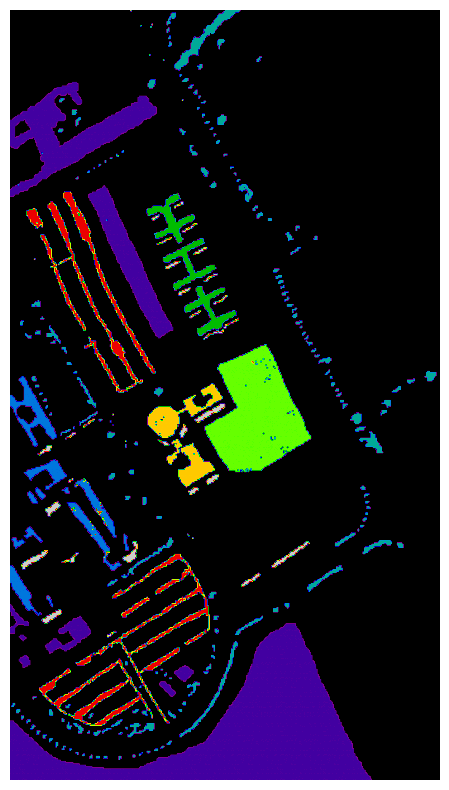

In [ ]:
class SWiGLU(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SWiGLU, self).__init__(**kwargs)

    def call(self, inputs):
        x, gate = tf.split(inputs, 2, axis=-1)
        return x * tf.sigmoid(gate) + x

def Positional_Encoding(max_len, d_emb):
    pos = np.arange(max_len)[:, np.newaxis]
    i = np.arange(d_emb)[np.newaxis, :]
    angles = pos / np.power(10000, 2 * i / d_emb)
    positional_encoding = np.zeros((max_len, d_emb))
    positional_encoding[:, ::2] = np.sin(angles[:, ::2])
    positional_encoding[:, 1::2] = np.cos(angles[:, 1::2])
    return positional_encoding[np.newaxis, ...]

class DMHSA(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model, dropout_rate=0.1, **kwargs):
        super(DMHSA, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads
        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)
        self.dense = Dense(d_model)
        self.dropout = Dropout(dropout_rate)
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    def differential_attention(self, scores):
        diff_scores = scores[:, 1:] - scores[:, :-1]
        diff_scores = tf.pad(diff_scores, [[0, 0], [1, 0], [0, 0], [0, 0]])
        return diff_scores
    def call(self, q, k, v, training):
        batch_size = tf.shape(q)[0]
        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)
        scores = tf.matmul(q, k, transpose_b=True)
        scores /= tf.math.sqrt(tf.cast(self.depth, tf.float32))
        diff_scores = self.differential_attention(scores)
        scores = scores + diff_scores
        attention_weights = tf.nn.softmax(scores, axis=-1)
        attention_weights = self.dropout(attention_weights, training=training)
        output = tf.matmul(attention_weights, v)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))
        return self.dense(output)

class SST(tf.keras.layers.Layer):
    def __init__(self, num_heads, transformer_layer_depth, d_model, dff, dropout_rate=0.1, layernorm_eps=1e-6, **kwargs):
        super(SST, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.transformer_layer_depth = transformer_layer_depth
        self.d_model = d_model
        self.dff = dff
        self.dropout_rate = dropout_rate
        self.layernorm_eps = layernorm_eps
        self.mha = DMHSA(num_heads=num_heads, d_model=d_model, dropout_rate=dropout_rate)
        self.dropout1 = Dropout(dropout_rate)
        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.dense1 = Dense(dff)
        self.swiGLU1 = SWiGLU()
        self.dense2 = Dense(d_model)
        self.dropout2 = Dropout(dropout_rate)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
    def call(self, inputs, training):
        x = inputs
        for _ in range(self.transformer_layer_depth):
            attn_output = self.mha(x, x, x, training=training)
            attn_output = self.dropout1(attn_output, training=training)
            attn_output = self.layernorm1(x + attn_output)
            ffn_output = self.dense1(attn_output)
            ffn_output = self.relu1(ffn_output)
            ffn_output = self.dense2(ffn_output)
            ffn_output = self.dropout2(ffn_output, training=training)
            ffn_output = self.layernorm2(attn_output + ffn_output)
            x = ffn_output
        return x

def DSST(WS, k, Num_Classes, num_transformer_layers=2, num_heads=4, dff=4 * 64, dropout_rate=0.1, layernorm_eps=1e-3):
    input_shape = (WS, WS, k)
    max_patch_size = min(input_shape[:3])
    patch_size = max_patch_size
    num_patches = ((input_shape[0] // patch_size) * (input_shape[1] // patch_size) * (input_shape[2] // patch_size))
    embedding_dim = 64
    inputs = Input(shape=input_shape, name="inputs")
    x = tf.expand_dims(inputs, axis=1)
    patch_embed = Conv3D(embedding_dim, kernel_size=(1, patch_size, patch_size),
                         strides=(1, patch_size, patch_size), padding="valid", name="patch_embed")(x)
    patch_embed = tf.reshape(patch_embed, (-1, tf.reduce_prod(tf.shape(patch_embed)[1:-1]), embedding_dim)) 
    cls_token = tf.Variable(tf.zeros((1, 1, embedding_dim)), name="cls_token")
    patch_embed = tf.concat([tf.broadcast_to(cls_token, [tf.shape(patch_embed)[0], 1, embedding_dim]), patch_embed], axis=1)
    pos_encoding = Positional_Encoding(num_patches + 1, embedding_dim)
    pos_encoding = tf.cast(pos_encoding, dtype=tf.float32)
    pos_encoding = tf.reshape(pos_encoding, (1, -1, embedding_dim))
    patch_embed = patch_embed + pos_encoding
    transformer_layer = patch_embed
    for i in range(num_transformer_layers):
        transformer_layer = SST(
            num_heads=num_heads,
            transformer_layer_depth=2,
            d_model=embedding_dim,
            dff=dff,
            name=f"transformer_layer_{i}",
        )(transformer_layer)

    transformer_layer = tf.reshape(transformer_layer, (-1, tf.shape(transformer_layer)[1], embedding_dim))
    cls_token_output = transformer_layer[:, 0, :] 
    output_layer = Dense(32, kernel_regularizer=regularizers.l2(0.01))(cls_token_output)
    output_layer = Dense(Num_Classes, activation="softmax", name="output_layer")(output_layer)
    model = Model(inputs=inputs, outputs=output_layer, name="DSST")
    return model

def DiffFormer(WS, k, Num_Classes, CRDHSI, GT, Tr, TrC, Va, VaC, Te, TeC, epochs, batch_size):
    model = DSST(WS, k, Num_Classes)
    model.summary()
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    start_time = time.time()
    history = model.fit(x=Tr, y=TrC, batch_size=batch_size, epochs=epochs, validation_data=(Va, VaC))
    training_time = time.time() - start_time
    Flops = compute_flops(model)
    trainable_parameters = model.count_params()
    start = time.time()
    Te_Pre = model.predict(Te)
    end = time.time()
    Te_Time = end - start
    classification, Confusion, OA, Per_Class, AA, Kappa = ClassificationReports(TeC, Te_Pre, target_names)
    print(classification)
    file_name = f"4_1_{HSID}_{trRatio}_{WS}_Classification_Report.csv"
    CSV_file = CSVResults(file_name, classification, Confusion, trainable_parameters,
                          Flops, training_time, Te_Time, Kappa, OA, AA, Per_Class)
    outputs = GT_Plot(CRDHSI, GT, model, WS, k)
    plt.figure(figsize=(10, 10))
    plt.imshow(outputs, cmap='nipy_spectral')
    plt.axis('off')
    file_name = f"4_1_{HSID}_{trRatio}_{WS}_Ground_Truths.png"
    plt.savefig(file_name, dpi=500, format='png', bbox_inches='tight', pad_inches=0)
    return history
DMHSA = DiffFormer(WS, k, Num_Classes, CRDHSI, GT, Tr, TrC, Va, VaC, Te, TeC, epochs=epochs, batch_size=batch_size)